In [ ]:
import time
import gym
import numpy as np
from gym import spaces
from tqdm import tqdm
import pandas as pd

import numpy as np
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

import sys
sys.path.append('E:\Anaconda\envs\gym-examples')
import gym_examples
from gym.wrappers import FlattenObservation

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# Train

For the sampling factor of 5, we use just 15 epoches.

if  dis <=0.3:
            reward = np.exp(-10*dis)
else:
            reward = 0

In [ ]:
env = gym.make('gym_examples/Poppy-v0')
env.reset()

In [ ]:
# from stable_baselines3.common.env_checker import check_env
# check_env(env)

In [ ]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.15 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1,batch_size = 57 )
model.learn(total_timesteps= 57*15)

info = pd.DataFrame(env.infos)
info.to_pickle('info.pkl')
# info = pd.read_pickle('info.pkl')

model.save("ddpg_imitation")
vec_env = model.get_env()


# Test
For training, we can stop here. We can begin the test.
We can clear all the history data firstly.

In [1]:
import time
import gym
import numpy as np
from gym import spaces
from tqdm import tqdm
import pandas as pd

import numpy as np
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

import sys
sys.path.append('E:\Anaconda\envs\gym-examples')
import gym_examples
from gym.wrappers import FlattenObservation

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

In [2]:
env = gym.make('gym_examples/Poppy-v0')
env.reset()

pygame 2.1.0 (SDL 2.0.16, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Hello, I am Poppy!


E:\Anaconda\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


array([ 0.10257855,  0.00415997, -0.10847217, -0.10551344, -0.00023938,
       -0.1085    ], dtype=float32)

In [3]:
model = DDPG.load("ddpg_imitation")

obs = env.reset()
k =0
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    k  += 5
    
    if k >= 286 :
        break
        obs = env.reset()
        k = 0
        


reward :  0
current step :  5
episode :  0
reward :  0
current step :  10
episode :  0
reward :  0
current step :  15
episode :  0
reward :  0
current step :  20
episode :  0
reward :  0
current step :  25
episode :  0
reward :  0
current step :  30
episode :  0
reward :  0.06026057910392684
current step :  35
episode :  0
reward :  0.1366728231658167
current step :  40
episode :  0
reward :  0.2280955066909602
current step :  45
episode :  0
reward :  0.1922196537309281
current step :  50
episode :  0
reward :  0.0971303086375319
current step :  55
episode :  0
reward :  0.0980593844686704
current step :  60
episode :  0
reward :  0.10237653015320221
current step :  65
episode :  0
reward :  0.10226251823150004
current step :  70
episode :  0
reward :  0.08954765757926686
current step :  75
episode :  0
reward :  0.07683109758497131
current step :  80
episode :  0
reward :  0.0743995134179756
current step :  85
episode :  0
reward :  0.08291672112443373
current step :  90
episode :  0

In [4]:
info = pd.DataFrame(env.infos)
info.to_pickle('info.pkl')

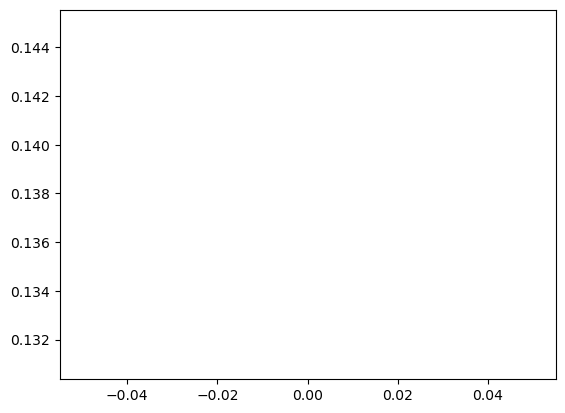

In [5]:
info = pd.read_pickle('info.pkl')
t=[]
for ep in info['episode'].unique():
      t.append(info[info['episode']==ep]['reward'].mean())
plt.plot(t)

In [6]:
env.get_obs()

array([ 1.06023309e-01,  3.64838174e-03,  5.47499507e-01, -1.05513436e-01,
       -2.39384351e-04, -1.08499994e-01])

In [7]:
np.linalg.norm([1,1],1)

2.0

In [8]:
env.reset()

array([ 0.08543036,  0.00327208, -0.10788821, -0.10551344, -0.00023938,
       -0.1085    ], dtype=float32)

In [9]:
env.reset()

array([ 0.10029976,  0.00354554, -0.10845953, -0.10551344, -0.00023938,
       -0.1085    ], dtype=float32)

In [10]:
env.poppy.l_shoulder_y.goto_position(-0,3,wait=True)
env.poppy.l_shoulder_x.goto_position(0,3,wait=True)
env.poppy.abs_z.goto_position(-0,3,wait=True)

In [11]:
env.poppy.r_shoulder_y.goto_position(-0,3,wait=True)
env.poppy.r_shoulder_x.goto_position(0,3,wait=True)
env.poppy.abs_z.goto_position(-0,3,wait=True)

In [12]:
joint_pos = { 'l_elbow_y':0.0,
                     'head_y': 0.0,
                     'r_arm_z': 0.0, 
                     'head_z': 0.0,
                     'r_shoulder_x': 0.0, 
                     'r_shoulder_y': 0.0,
                     'r_elbow_y': 0.0, 
                     'l_arm_z': 0.0,
                     'abs_z': 0.0,
                     'bust_y': 0.0, 
                     'bust_x':0.0,
                     'l_shoulder_x': 0.0,
                     'l_shoulder_y': 0.0
                    }
        
for m in env.poppy.motors:
               m.goto_position(joint_pos[m.name], 3, wait= True)
        